In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import warnings
from itertools import tee

# Suppress scientific notation
pd.options.display.float_format = '{:20,.2f}'.format

warnings.filterwarnings("ignore")

## 1. Data Pre-Processing
1. Join session level data with track context/features
2. Identify all unique transitions from song a to song b --> store in dictionary for future sampling during training
3. Convert rewards to binary 0 = skipped, 1 = not skipped
4. Encode categorical track and session features
5. Create Features dataframe which containes cleaned/OHE vector of track features
6. Normalize the session level response to song features on a 0-1 scale


In [4]:
# Load in Data
df_sessions_sampled = pd.read_csv('data/training_set/log_sampled.csv')
df_tracks_sampled = pd.read_csv('data/track_features/tf_sampled.csv')
print("Number of sessions in DF: " + str(len(df_sessions_sampled['session_id'].unique())))
print("Number of tracks in DF: " + str(len(df_tracks_sampled['track_id'].unique())))
# Sanity check num tracks in tracks df equals num tracks in sessions df
assert len(df_sessions_sampled['track_id_clean'].unique()) == len(df_tracks_sampled['track_id'].unique())

Number of sessions in DF: 178342
Number of tracks in DF: 319008


In [5]:
## Join dataframes together on 'track_id'
spotify = df_sessions_sampled.merge(df_tracks_sampled, left_on="track_id_clean", right_on="track_id")

In [6]:
# response = -1, track was skipped 
# response = 1, track was not skipped
spotify['response'] = np.where(
    spotify['not_skipped']==True,
    1, -1)
spotify = spotify.drop(columns=['skip_1', 'skip_2', 'skip_3', 'not_skipped'])

In [7]:
spotify['response'].value_counts()

-1    1985901
 1    1004708
Name: response, dtype: int64

## Encode relevant user context data - behavior
To booleans:
- shuffle (0/1)
- premium (0/1)

To numeric:
- date --> year, month

To OHE vectors:
- context (catalog, charts, editorial playlist, personalized playlist, radio, user collection)
- track end reason (appload, backbtn, clickrow, endplay, fwdbtn, logout, remote, trackdone)

In [8]:
# Convert binary columns to booleans
data_bool_cols = spotify.columns[spotify.dtypes=='bool']
for col in data_bool_cols:
    spotify[col]=spotify[col].astype(int)
spotify['mode'] = np.where(spotify['mode']=='major', 1,0)

In [9]:
from datetime import datetime
spotify['date'] = pd.to_datetime(spotify.date, format='%Y-%m-%d')
spotify['year']=spotify['date'].dt.year
spotify['month']=spotify['date'].dt.month
# spotify = spotify.drop(columns='date')

In [10]:
# OHE Categorical Columns
spotify['hist_user_behavior_reason_end'] = spotify['hist_user_behavior_reason_end']+'_end'
spotify['hist_user_behavior_reason_start'] = spotify['hist_user_behavior_reason_start']+'_start'

categorical_columns =['context_type', 'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end']
enc = OneHotEncoder()
array_hot_encoded = enc.fit_transform(spotify[categorical_columns]).toarray()
feature_labels = enc.categories_
feature_labels = np.concatenate(feature_labels, axis=0)
data_hot_encoded = pd.DataFrame(array_hot_encoded, columns=feature_labels, index=spotify.index) # Convert OHE array to df
spotify = spotify.drop(columns=categorical_columns)
spotify_enc = pd.concat([spotify, data_hot_encoded], axis=1)
spotify_enc.head()

,session_id,session_position,session_length,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,...,appload_end,backbtn_end,clickrow_end,endplay_end,fwdbtn_end,logout_end,popup_end,remote_end,trackdone_end,uriopen_end
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,0_00079a23-1600-486a-91bd-5208be0c745a,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,6,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,9,13,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,1,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00


In [21]:
len(spotify_enc.columns)

74

In [12]:
data_bool_objects = spotify_enc.columns[spotify_enc.dtypes=='object']
data_bool_objects

Index(['session_id', 'track_id_clean', 'track_id'], dtype='object')

In [13]:
ori_columns = ['session_position', 'session_length', 'context_switch', 'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'premium','duration',
       'release_year', 'us_popularity_estimate', 'acousticness',
       'beat_strength', 'bounciness', 'danceability', 'dyn_range_mean',
       'energy', 'flatness', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mechanism', 'mode', 'organism', 'speechiness', 'tempo',
       'time_signature', 'valence', 'acoustic_vector_0', 'acoustic_vector_1',
       'acoustic_vector_2', 'acoustic_vector_3', 'acoustic_vector_4',
       'acoustic_vector_5', 'acoustic_vector_6', 'acoustic_vector_7',
       'response', 'year', 'month', 'catalog', 'charts', 'editorial_playlist',
       'personalized_playlist', 'radio', 'user_collection', 'appload_start',
       'backbtn_start', 'clickrow_start', 'endplay_start', 'fwdbtn_start',
       'playbtn_start', 'popup_start', 'remote_start', 'trackdone_start',
       'trackerror_start', 'uriopen_start', 'appload_end', 'backbtn_end',
       'clickrow_end', 'endplay_end', 'fwdbtn_end', 'logout_end', 'popup_end',
       'remote_end', 'trackdone_end', 'uriopen_end']

In [22]:
len(ori_columns)

70

In [ ]:
# Normalize all features to be between 0 and 1
for i in ori_columns:
    # print(i)
    #spotify_enc[i] /= np.max(np.abs(spotify_enc[i]),axis=0) # Between -1 and 1
    spotify_enc[i] = (spotify_enc[i]-np.min(spotify_enc[i]))/(np.max(spotify_enc[i])-np.min(spotify_enc[i]))

In [15]:
spotify_enc.describe()

,session_position,session_length,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,...,appload_end,backbtn_end,clickrow_end,endplay_end,fwdbtn_end,logout_end,popup_end,remote_end,trackdone_end,uriopen_end
count,"2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00",...,"2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00"
mean,0.44,0.76,0.04,0.77,0.15,0.17,0.00,0.00,0.30,0.61,...,0.00,0.08,0.00,0.09,0.48,0.00,0.00,0.00,0.35,0.00
std,0.29,0.34,0.20,0.42,0.35,0.38,0.00,0.00,0.46,0.26,...,0.00,0.27,0.00,0.28,0.50,0.06,0.00,0.04,0.48,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.21,0.50,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.48,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.42,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.65,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.68,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.83,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [49]:
len(np.unique(spotify_enc['session_id']))

178342

In [38]:
np.sum(spotify_enc['session_id'].value_counts()==20)

89672

In [39]:
np.sum(spotify_enc['session_id'].value_counts()<20)

88670

In [111]:
# select sessions with 20 songs/tracks
session_id_20 = np.array([i[0] for i in dict(spotify_enc['session_id'].value_counts()==20).items() if i[1]==True])
spotify_enc_20 = spotify_enc[spotify_enc['session_id'].isin(session_id_20)]

## 2. Feature Selection: TBD

## 3. Model Building

In [17]:
def calculate_regret(selected_rated, inventory_ratings):
    return max(inventory_ratings) - selected_rated

In [203]:
x_dimension = 70
num_context = 15
input_size = (x_dimension*num_context)+(x_dimension-1)
output_size = 2

print('number of input features: ', input_size)

number of input features:  1119


In [204]:
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

from keras.layers import Dense
model = Sequential() 
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, dropout=0.5, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32)) 
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
# history = model.fit(x_train,one_hot_train_labels, epochs=20, batch_size=128, validation_data = (x_test, one_hot_test_labels))

In [ ]:
# Some better models that can be experimented: 1D-CNN
# from keras.models import Sequential
# from keras import layers
# from keras.optimizers import RMSprop
# model = Sequential()
# model.add(layers.Embedding(10000, 32))
# model.add(layers.Conv1D(32, 7, activation='relu'))
# model.add(layers.MaxPooling1D(5))
# model.add(layers.Conv1D(32, 7, activation='relu'))
# model.add(layers.GlobalMaxPooling1D())
# model.add(layers.Dropout(0.1))
# model.add(Dense(1, activation='sigmoid'))
# model.summary()
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])


In [ ]:
# # Some better models that can be experimented: LSTM
# from keras.layers import LSTM
# model = Sequential()
# model.add(Embedding(10000, 64))
# model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

In [207]:
def eps_greedy(model, session_context, track_inventory, eps):
    selected_track = None
    selected_x = None
    max_action_val = -100
    ids = list(range(5))
    
    # IF A RANDOM NUMBER BETWEEN 0 AND 1 IS LESS THAN OUR EPS HYPERPARAMETER WE CHOOSE A RANDOM AD
    if np.random.uniform() < eps:
        selected_track = np.random.choice(ids)
        selected_x = np.concatenate((session_context,track_inventory[selected_track]), axis = None).reshape(input_size,)

    # OTHERWISE WE GET THE AD(S) WITH THE HIGHEST PREDICTED CTR(S)
    else:
        context = np.array([np.concatenate((session_context, i)) for i in track_invetory])
        predictions = model.predict(context, verbose = 0) # set verbose = 0, so keras prediction would not print sth. like: 1/1 [==============================] - 0s 29ms/step
        selected_track = np.argmax(predictions)
        selected_x = context[selected_track]
        
    return selected_track, selected_x.reshape(input_size,)

In [208]:
import math
impressions = 10000
batch_size = 128
eps = [0.05] 
regret_vec = {}
train_loss = []
for e in eps:
    print('e = ',e, '\n')
    movie_model = model
    X = []
    y = []
    total_regret = 0
    regret_vec[e] = []
    
    for i in range(impressions):
        # sample a session
        session_id_sample = np.array(spotify_enc_20.sample(n = 1))[0][0]
        
        # sample last 15 songs within the session as the session context (including session-related and track-related features)
        session_context = np.array(spotify_enc_20[spotify_enc_20.session_id == session_id_sample][:15][ori_columns]).flatten() # 1050 features
        
        # remaining 5 songs within the session as the track inventories (after remove reponse column)
        track_inventory_all = spotify_enc_20[spotify_enc_20.session_id == session_id_sample][15:][ori_columns]
        track_invetory = np.array(track_inventory_all.loc[:,track_inventory_all.columns!='response'])
        
        # true response for these five songs
        track_response = np.array(track_inventory_all['response'])
        
        # use eps-greedy strategy with RNN model to choose a track
        selected_track_id, selected_x = eps_greedy(model, session_context, track_invetory, e)        
        
        # get select track response and calculate regret
        selected_response = track_response[selected_track_id]
        regret = calculate_regret(selected_response, track_response)
        
        # SAVE SELECTED CONTEXT, REWARD, REGRET AND TOTAL REGRET
        if math.isnan(selected_response):
            continue
        else:
            X.append(selected_x)
            y.append(selected_response)

        total_regret += regret
        regret_vec[e].append(total_regret)
        
        idx = batch_size

        # UPDATE THE MODEL AT THE END OF THE BATCH
        if (i + 1)%batch_size == 0:
            print('Updating the model after {} impressions'.format(i+1))
            train_x = np.array(X[idx-batch_size:idx])
            train_y = np.array(y[idx-batch_size:idx])

            # print(train_x.shape)
            # print(train_y.shape)        
            idx+=batch_size
            model.fit(train_x, train_y)


e =  0.05 

Updating the model after 128 impressions
4/4 [==============================] - 6s 1s/step - loss: 0.6449 - accuracy: 0.6641
Updating the model after 256 impressions
4/4 [==============================] - 3s 764ms/step - loss: 0.6058 - accuracy: 0.6797
Updating the model after 384 impressions
4/4 [==============================] - 3s 751ms/step - loss: 0.5372 - accuracy: 0.7422
Updating the model after 512 impressions
4/4 [==============================] - 3s 756ms/step - loss: 0.5501 - accuracy: 0.7500
Updating the model after 640 impressions
4/4 [==============================] - 3s 752ms/step - loss: 0.4020 - accuracy: 0.8359
Updating the model after 768 impressions
4/4 [==============================] - 3s 734ms/step - loss: 0.3886 - accuracy: 0.8359
Updating the model after 896 impressions
4/4 [==============================] - 3s 736ms/step - loss: 0.3807 - accuracy: 0.8125
Updating the model after 1024 impressions
4/4 [==============================] - 3s 738ms/step 

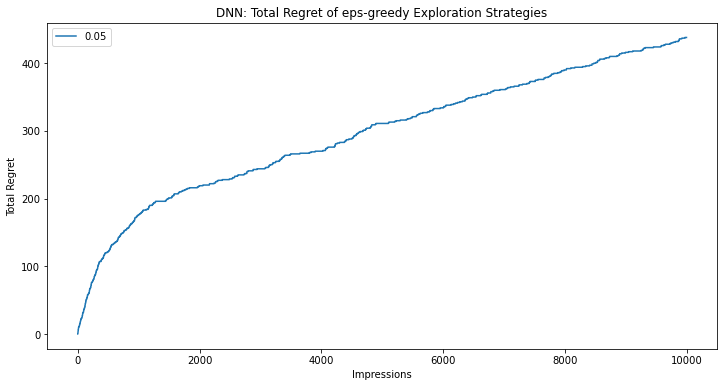

In [210]:
fig, ax = plt.subplots(figsize=(12, 6))
for e in eps:
    ax.plot(range(len(regret_vec[e])), regret_vec[e])
ax.set_ylabel('Total Regret')
ax.set_xlabel('Impressions')
ax.set_title('DNN: Total Regret of eps-greedy Exploration Strategies')
ax.legend(eps)
plt.show()